1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.
4. Compute latent feature vectors of images. (The output of the encoder network)
5. Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.
6. Repeat the previous step with TSNE.
7. What do you conclude from steps 4 and 5 about the learned latent representation of the data?

Bonus:
1. Create a data loader that rotates input images with a random degree.
2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.

Useful links:
- [AE](https://medium.com/@AnasBrital98/autoencoders-explained-da131e60e02a)
- [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [PCA](https://towardsdatascience.com/the-most-gentle-introduction-to-principal-component-analysis-9ffae371e93b#:~:text=From%20Wikipedia%2C%20PCA%20is%20a,find%20unmeasured%20%E2%80%9Clatent%20variables%E2%80%9D.)
- [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

In [92]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision.transforms.functional import rotate

from tqdm import tqdm
from matplotlib import pyplot as plt

In [93]:
batch_size = 60
val_rate = 0.1
num_workers = 2
device = torch.device('cuda')
epochs = 15

In [94]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
]    
)

mnist_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)


In [95]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, variance=0.5):
        self.dataset = dataset
        self.variance = variance

    def __getitem__(self, index):
        img, label = self.dataset[index]
        noise = torch.randn(img.size()) * self.variance  #N(0, variance)
        noisy_img = img + noise
        return noisy_img, img, label
        

    def __len__(self):
        return len(self.dataset)


In [96]:
noisy_mnist_train = NoisyDataset(mnist_train, 0.3)
noisy_mnist_test = NoisyDataset(mnist_test, 0.3)

train_loader = torch.utils.data.DataLoader(
    noisy_mnist_train, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    noisy_mnist_test, batch_size=batch_size, shuffle=True
)


(60, 1, 28, 28)


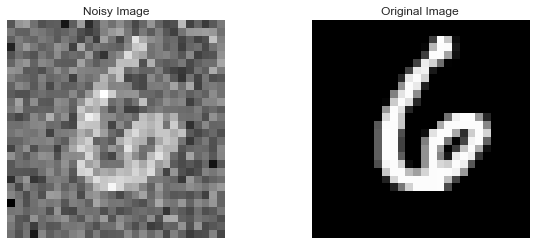

In [97]:
#print some images after adding noise
dataiter = iter(train_loader)
image, original, _ = dataiter.next()
image = image.numpy()
original = original.numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].axis('off')
axs[0].imshow(np.squeeze(image[0]), cmap='gray')
axs[0].set_title('Noisy Image')
axs[1].axis('off')
axs[1].imshow(np.squeeze(original[0]), cmap='gray')
axs[1].set_title('Original Image')

print(original.shape)


In [98]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AutoEncoder, self).__init__()

        def encoder(in_dim, hidden_dim):
            return nn.Sequential(
				nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same'),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same'),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Flatten(),
                nn.Linear(7 * 7 * 32, 256),
                nn.LeakyReLU(),
                nn.Linear(256, hidden_dim),
            )
        
        def decoder(in_dim, out_dim):
            return nn.Sequential(
                nn.Linear(hidden_dim, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 7 * 7 * 32),
                nn.LeakyReLU(),
                nn.Unflatten(1, (32, 7, 7)),
                nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid(), #Because the input is normalized to [0, 1] :"),
            )
                
        
        self.encoder = encoder(input_dim, hidden_dim)
        self.decoder = decoder(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [99]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
hidden_dim = 5
model = AutoEncoder(28, hidden_dim, 28)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)

for epoch in range(epochs):
    running_loss = 0.0
    for noisy_img, original, _ in tqdm(train_loader):
        optimizer.zero_grad()
        batch_length = noisy_img.shape[0]
        noisy_img = noisy_img.to(device)
        original = original.to(device)
        outputs = model(noisy_img)
        loss = criterion(outputs, original)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_length
    print("Epoch: {} \tTraining Loss: {:.3f}".format(epoch, running_loss / len(train_loader.dataset)))
        
    


Using GPU


100%|██████████| 1000/1000 [00:23<00:00, 42.75it/s]


Epoch: 0 	Training Loss: 0.045


100%|██████████| 1000/1000 [00:24<00:00, 41.51it/s]


Epoch: 1 	Training Loss: 0.029


100%|██████████| 1000/1000 [00:23<00:00, 42.29it/s]


Epoch: 2 	Training Loss: 0.027


100%|██████████| 1000/1000 [00:23<00:00, 42.13it/s]


Epoch: 3 	Training Loss: 0.026


100%|██████████| 1000/1000 [00:22<00:00, 43.62it/s]


Epoch: 4 	Training Loss: 0.025


100%|██████████| 1000/1000 [00:23<00:00, 43.24it/s]


Epoch: 5 	Training Loss: 0.024


100%|██████████| 1000/1000 [00:22<00:00, 44.11it/s]


Epoch: 6 	Training Loss: 0.024


100%|██████████| 1000/1000 [00:23<00:00, 43.11it/s]


Epoch: 7 	Training Loss: 0.023


100%|██████████| 1000/1000 [00:24<00:00, 41.53it/s]


Epoch: 8 	Training Loss: 0.023


100%|██████████| 1000/1000 [00:22<00:00, 43.90it/s]


Epoch: 9 	Training Loss: 0.023


100%|██████████| 1000/1000 [00:25<00:00, 39.97it/s]


Epoch: 10 	Training Loss: 0.022


100%|██████████| 1000/1000 [00:23<00:00, 42.40it/s]


Epoch: 11 	Training Loss: 0.022


100%|██████████| 1000/1000 [00:23<00:00, 43.40it/s]


Epoch: 12 	Training Loss: 0.022


100%|██████████| 1000/1000 [00:24<00:00, 41.62it/s]


Epoch: 13 	Training Loss: 0.022


100%|██████████| 1000/1000 [00:23<00:00, 42.10it/s]

Epoch: 14 	Training Loss: 0.022


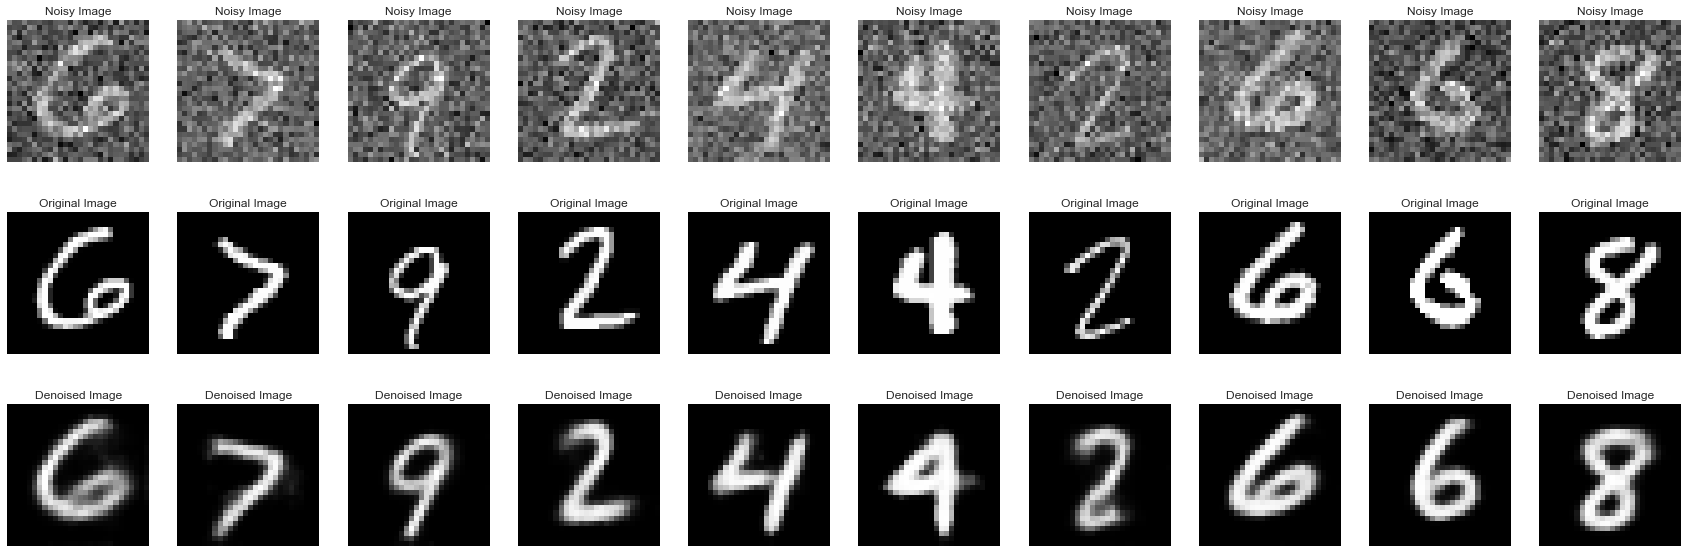

In [100]:
fig, axs = plt.subplots(3, 10, figsize=(30, 10))
with torch.no_grad():
    #generate 10 random indexes
    idxs = np.random.randint(0, len(noisy_mnist_test), 10)  
    for i in range(10):
        noisy_img, original, _ = noisy_mnist_test[idxs[i]]
        noisy_img = noisy_img.to(device)
        original = original.to(device)
        noisy_img = noisy_img.unsqueeze(0)
        output = model(noisy_img)
        output = output.cpu()
        noisy_img = noisy_img.cpu()
        original = original.cpu()
        axs[0][i].imshow(np.squeeze(noisy_img), cmap='gray')
        axs[2][i].imshow(np.squeeze(output), cmap='gray')
        axs[1][i].imshow(np.squeeze(original), cmap='gray')
        axs[0][i].axis('off')
        axs[2][i].axis('off')
        axs[1][i].axis('off')
        #put title only on the first row on the left
        axs[0][i].set_title('Noisy Image')
        axs[1][i].set_title('Original Image')
        axs[2][i].set_title('Denoised Image')


In [101]:
from tqdm import tqdm
import pandas as pd

encoder = model.encoder
decoder = model.decoder
colors = []
encoded_samples = []
for img, _, labels in tqdm(test_loader):
	img = img.to(device)
	encoder.eval()
	with torch.no_grad():
	    encoded_img = encoder(img)
	for i in range(img.shape[0]):
		encoded_sample = encoded_img[i].cpu().numpy()
		colors.append(labels[i].item())						
		encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)



100%|██████████| 167/167 [00:03<00:00, 44.00it/s]


In [102]:
print(encoded_samples.shape)

(10000, 5)


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

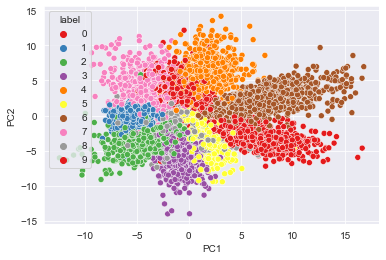

In [103]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(encoded_samples)
latent_pca = pca.transform(encoded_samples)

#Dataframe
df = pd.DataFrame(latent_pca, columns=['PC1', 'PC2'])
df['label'] = colors

#SNS
import seaborn as sns
sns.set_style('darkgrid')
sns.scatterplot(x='PC1', y='PC2', hue='label', data=df, palette='Set1')


C:\Users\hogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\hogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='var1', ylabel='var2'>

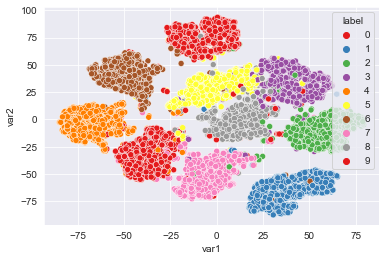

In [107]:
#TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
latent_tsne = tsne.fit_transform(encoded_samples)

#Dataframe
df = pd.DataFrame(latent_tsne, columns=['var1', 'var2'])
df['label'] = colors

#SNS
import seaborn as sns
sns.set_style('darkgrid')
sns.scatterplot(x='var1', y='var2', hue='label', data=df, palette='Set1')


### Latent Dimension is a set of features which describe the image best as the plots clearly show, each image is a cluster in latent space which is as we expected, a small problem is that the distance between clusters is visible which can be solved using VAE as they have smoother Latent Space because of KL divergance Regularization

In [108]:
#now lets train the variational auto encoder



transform = transforms.Compose([transforms.RandomRotation(90), transforms.ToTensor(),])

class RotatedMNIST(torch.utils.data.Dataset):
    def __init__(self, transform, dataset):
        super(RotatedMNIST, self).__init__()
        self.transform = transform
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        original, target = self.dataset[index]
        img = transforms.ToPILImage()(original)
        img = self.transform(img)
        return img, original, target

rotated_mnist_train = RotatedMNIST(transform, mnist_train)
rotated_mnist_test = RotatedMNIST(transform, mnist_test)

train_loader = torch.utils.data.DataLoader(rotated_mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(rotated_mnist_test, batch_size=64, shuffle=True)


class VAE(nn.Module):
    def __init__(self, hidden_dim):
        super(VAE, self).__init__()
        self.hidden_dim = hidden_dim
        def encoder(hidden_dim):
            return nn.Sequential(
				nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same'),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same'),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Flatten(),
                nn.Linear(7 * 7 * 32, 256),
                nn.LeakyReLU(),
                nn.Linear(256, hidden_dim * 2),
            )
        
        def decoder(in_dim, out_dim):
            return nn.Sequential(
                nn.Linear(hidden_dim, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 7 * 7 * 32),
                nn.LeakyReLU(),
                nn.Unflatten(1, (32, 7, 7)),
                nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid(), #Because the input is normalized to [0, 1] :"),
            )
        self.encoder = encoder(hidden_dim)
        self.decoder = decoder(hidden_dim, 1)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        z = self.encoder(x)
        mu, logvar = z[:, :self.hidden_dim], z[:, self.hidden_dim:]
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


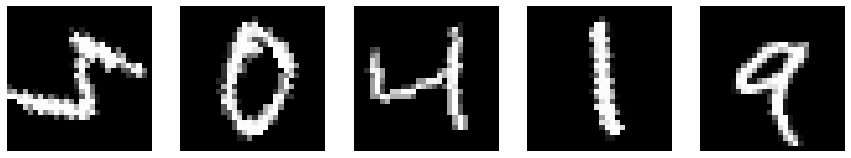

In [109]:
#show 5 sample rotated images
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    print(rotated_mnist_train[i][0].shape)
    axs[i].imshow(rotated_mnist_train[i][0].squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()


In [110]:
def loss_function(x_hat, x, mu, logvar):
    return F.binary_cross_entropy(x_hat, x, reduction='sum') + 0.5 * torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar)

model = VAE(64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

print(device)
for epoch in range(epochs):
    running_loss = 0.0
    for rotated, original,_ in tqdm(train_loader):
        optimizer.zero_grad()
        batch_length = rotated.shape[0]
        rotated = rotated.to(device)
        original = original.to(device)
        x_hat, mu, logvar = model(rotated)
        loss = loss_function(x_hat, original, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_length
    print("Epoch: {} \tTraining Loss: {:.3f}".format(epoch, running_loss / len(train_loader.dataset)))
        

cuda


100%|██████████| 938/938 [00:58<00:00, 15.98it/s]


Epoch: 0 	Training Loss: 12086.766


100%|██████████| 938/938 [00:49<00:00, 18.89it/s]


Epoch: 1 	Training Loss: 9703.690


100%|██████████| 938/938 [00:47<00:00, 19.57it/s]


Epoch: 2 	Training Loss: 9079.802


100%|██████████| 938/938 [00:48<00:00, 19.17it/s]


Epoch: 3 	Training Loss: 8744.987


100%|██████████| 938/938 [00:51<00:00, 18.17it/s]


Epoch: 4 	Training Loss: 8530.341


100%|██████████| 938/938 [00:52<00:00, 17.73it/s]


Epoch: 5 	Training Loss: 8359.485


100%|██████████| 938/938 [01:02<00:00, 14.99it/s]


Epoch: 6 	Training Loss: 8226.492


100%|██████████| 938/938 [01:00<00:00, 15.39it/s]


Epoch: 7 	Training Loss: 8131.759


100%|██████████| 938/938 [01:02<00:00, 15.03it/s]


Epoch: 8 	Training Loss: 8051.883


100%|██████████| 938/938 [01:00<00:00, 15.53it/s]


Epoch: 9 	Training Loss: 7987.045


100%|██████████| 938/938 [01:02<00:00, 15.05it/s]


Epoch: 10 	Training Loss: 7930.272


100%|██████████| 938/938 [00:58<00:00, 16.12it/s]


Epoch: 11 	Training Loss: 7877.207


100%|██████████| 938/938 [00:58<00:00, 15.98it/s]


Epoch: 12 	Training Loss: 7842.234


100%|██████████| 938/938 [00:58<00:00, 16.03it/s]


Epoch: 13 	Training Loss: 7791.711


100%|██████████| 938/938 [01:01<00:00, 15.23it/s]

Epoch: 14 	Training Loss: 7747.075


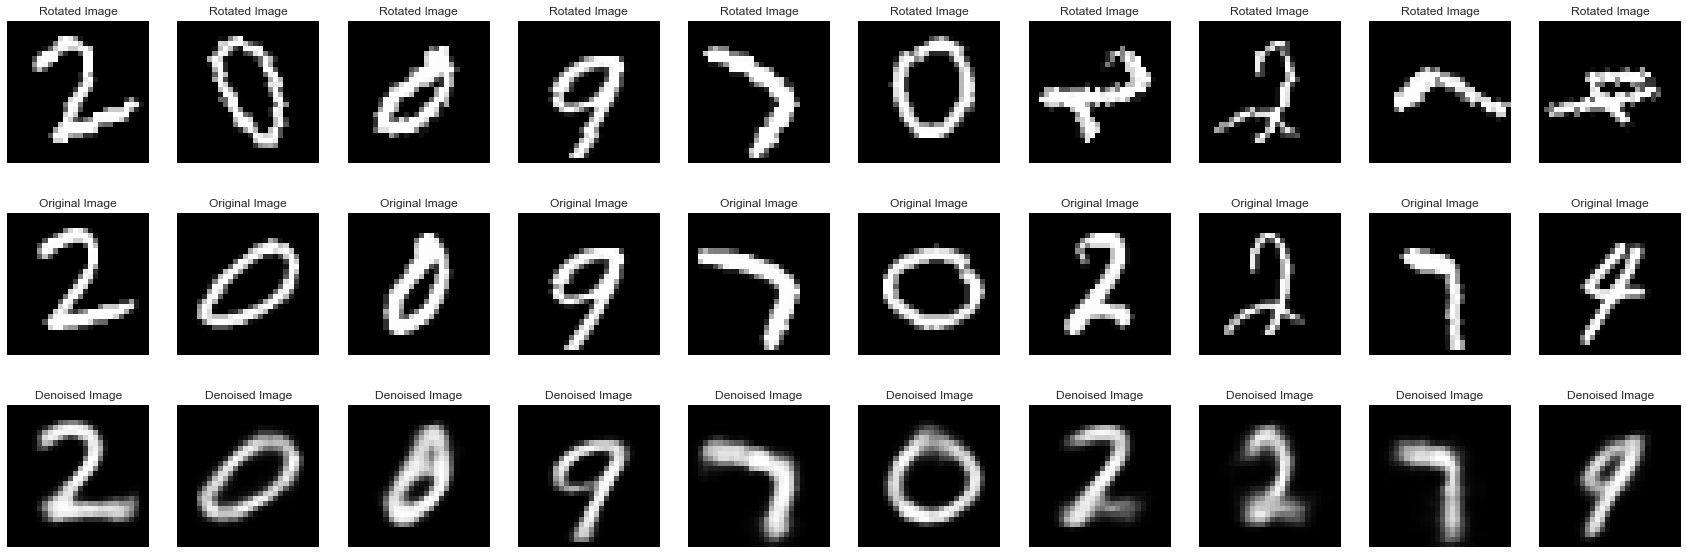

In [111]:
fig, axs = plt.subplots(3, 10, figsize=(30, 10))
with torch.no_grad():
    #generate 10 random indexes
    idxs = np.random.randint(0, len(rotated_mnist_test), 10)  
    for i in range(10):
        rotated, original, _ = rotated_mnist_test[idxs[i]]
        rotated = rotated.to(device)
        original = original.to(device)
        rotated = rotated.unsqueeze(0)
        output,_,_ = model(rotated)
        output = output.cpu()
        rotated = rotated.cpu()
        original = original.cpu()
        axs[0][i].imshow(np.squeeze(rotated), cmap='gray')
        axs[2][i].imshow(np.squeeze(output), cmap='gray')
        axs[1][i].imshow(np.squeeze(original), cmap='gray')
        axs[0][i].axis('off')
        axs[2][i].axis('off')
        axs[1][i].axis('off')
        #put title only on the first row on the left
        axs[0][i].set_title('Rotated Image')
        axs[1][i].set_title('Original Image')
        axs[2][i].set_title('Denoised Image')


some parts that i used copilot for help

the plots

reparametraziation trick (mu-log var) + VAE loss (KL Divergance + BCE Loss (https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes/370048#370048 (Proof is here)))